In [1]:
import numpy as np
import torch
from scipy.io import loadmat
import math
import matplotlib.pyplot as plt

#### Loading matrices

In [2]:
mat1 = loadmat('ForceVec_1225.mat')
mat2 = loadmat('Stiffness_1225.mat')

In [3]:
ForceVec = torch.from_numpy(mat1['B']).float()
stiffness = torch.from_numpy(mat2['K']).float()

In [4]:
dim = int(mat1['B'].shape[0])

#### Seed

In [5]:
def seed_lib():
    # RANDOM_SEED = 50
    # np.random.seed(RANDOM_SEED)
    # torch.manual_seed(RANDOM_SEED)
    return 

#### inverse_matrix

In [6]:
%%time
inverse_matrix = torch.linalg.inv(stiffness) @ ForceVec

CPU times: user 844 ms, sys: 288 ms, total: 1.13 s
Wall time: 1.47 s


#### steepest descent

In [7]:
def steepest_descent(A,b,x,for_plot = False):

    if (A != torch.t(A)).any():
        raise ValueError('Matrix A needs to be symmetric positive definite (SPD)')
    
    residual = b - A @ x
    num_iter = 0
    residual_norm_init = (residual.T @ residual)
    residual_norm_curr = residual_norm_init
    epsilon = 1e-10
    while (residual_norm_curr > (epsilon)*residual_norm_init):

        temp = A @ residual
        alpha = residual_norm_curr/(residual.T @ temp)
        x = x + (alpha * residual)

        if num_iter%10 == 0:
            residual = b - A @ x

        else:
            residual = residual - (alpha * temp)

        residual_norm_curr = (residual.T @ residual)
        num_iter += 1

    return x,num_iter

In [8]:
%%time
seed_lib()
starting_x = torch.rand(dim,1)
x_steepest,iter_steepest = steepest_descent(stiffness,ForceVec,starting_x)

CPU times: user 16.2 s, sys: 180 ms, total: 16.3 s
Wall time: 9.38 s


In [9]:
iter_steepest

7444

In [10]:
torch.dist(x_steepest,inverse_matrix,2)

tensor(7.1112)

#### complexity_of_SD

In [11]:
lambda_max = float(torch.lobpcg(stiffness,k = 1,largest = True)[0])
lambda_min = float(torch.lobpcg(stiffness,k = 1,largest = False)[0])
print(lambda_max,lambda_min)
condition_number = int(abs(lambda_max/lambda_min))
print(condition_number)

/home/lohith/chida/environments/basic/lib/python3.7/site-packages/torch/_lobpcg.py:946: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Rinv = torch.triangular_solve(Id, R, upper=True).solution


9.979907989501953 0.00477374903857708
2090


In [12]:
omega_max = (iter_steepest-1)/(iter_steepest+1)
print(omega_max)
epsilon = 1e-10
steepest_max_iter = math.log(1/(epsilon))/math.log((condition_number+1)/(condition_number-1))
print(int(steepest_max_iter))

0.9997313633310947
24062


$ O(max(sparsity,n)*steepest\_max\_iter) = O(n*steepest\_max\_iter) $

$ steepest\_max\_iter = \frac{ln(1/ϵ)}{ln\big(\frac{κ+1}{κ-1}\big)} $

$ κ = \frac{λ_{max}}{λ_{min}} $

#### Conjugate_gradient

In [13]:
def conjugate_gradient(A,b,x,n):

    if (A != torch.t(A)).any():
        raise ValueError('Matrix A needs to be symmetric positive definite (SPD)')

    r = b - A @ x
    d = r
    num_iter = 0
    residual_norm_init = (r.T @ r)
    residual_norm_curr = residual_norm_init
    epsilon = 1e-10

    while (residual_norm_curr > (epsilon)*residual_norm_init and num_iter < n):

        p = A @ d
        alpha = residual_norm_curr/(d.T @ p)
        x = x + alpha * d
        if num_iter%10 == 0:
            r = b - A @ x
        else:
            r = r - alpha * p
        temp = residual_norm_curr
        residual_norm_curr = r.T @ r
        beta = residual_norm_curr/temp
        d = r + beta * d
        num_iter = num_iter + 1

    return x,num_iter

In [14]:
%%time
seed_lib()
x_conjugate,iter_conjugate = conjugate_gradient(stiffness,ForceVec,starting_x,dim)

CPU times: user 428 ms, sys: 16 ms, total: 444 ms
Wall time: 339 ms


In [15]:
iter_conjugate

133

In [16]:
torch.dist(x_conjugate,inverse_matrix,2)

tensor(0.1630)

#### Complexity_of_CG

In [17]:
epsilon = 1e-10
temp = math.sqrt(condition_number)
conjugate_max_iter = int(math.log(2/(epsilon))/math.log((temp+1)/(temp-1)))
print(conjugate_max_iter)
omega = ((temp-1)/(temp+1))
print(omega)

542
0.9571885899448063


$O(max(sparsity,n)*conjugate\_max\_iter) = O(n*conjugate\_max\_iter)$

$conjugate\_max\_iter = min\Big(\frac{ln(2/ϵ)}{ln\big(\frac{\sqrt{k}+1}{\sqrt{k} -1}\big)},n \Big)$

$κ = \frac{λ_{max}}{λ_{min}}$

#### Comparision_between_SD_CG

In [18]:
def comp_steepest_descent(A,b,x,epsilon = 1e-10):

    if (A != torch.t(A)).any():
        raise ValueError('Matrix A needs to be symmetric positive definite (SPD)')

    residual = b - A @ x
    num_iter = 0
    acc_sd = {}
    residual_norm_init = (residual.T @ residual)
    residual_norm_curr = residual_norm_init
    epsilon = 1e-10
    while (residual_norm_curr > (epsilon)*residual_norm_init):

        temp = A @ residual
        alpha = residual_norm_curr/(residual.T @ temp)
        x = x + (alpha * residual)

        if num_iter%10 == 0:
            residual = b - A @ x
            acc_sd[num_iter] = torch.dist(x,inverse_matrix,2)

        else:
            residual = residual - (alpha * temp)

        residual_norm_curr = (residual.T @ residual)
        num_iter += 1

    return x,num_iter,acc_sd

def comp_conjugate_gradient(A,b,x,n,epsilon = 1e-10):

    if (A != torch.t(A)).any():
        raise ValueError('Matrix A needs to be symmetric positive definite (SPD)')

    r = b- A @ x
    d = r
    num_iter = 0
    residual_norm_init = (r.T @ r)
    residual_norm_curr = residual_norm_init
    acc_cg = {}
    while (residual_norm_curr > (epsilon)*residual_norm_init and num_iter < n):
        p = A @ d
        alpha = residual_norm_curr/(d.T @ p)
        x = x + alpha * d
        if num_iter%10 == 0:
            r = b - A @ x
            acc_cg[num_iter] = torch.dist(x,inverse_matrix,2)
        else:
            r = r - alpha * p
        temp = residual_norm_curr
        residual_norm_curr = r.T @ r
        beta = residual_norm_curr/temp
        d = r + beta * d
        num_iter = num_iter + 1

    return x,num_iter,acc_cg


In [19]:
x_sd,iter_sd,acc_sd = comp_steepest_descent(stiffness,ForceVec,starting_x)
x_cg,iter_cg,acc_cg = comp_conjugate_gradient(stiffness,ForceVec,starting_x,dim)

In [20]:
final_steepest_norm = torch.dist(x_sd,inverse_matrix,2)
final_conjugate_norm = torch.dist(x_cg,inverse_matrix,2)

In [21]:
print(f'Norm difference of final solution obtained by steepest_descent after {iter_sd} iterations is {final_steepest_norm}')
print(f'Norm difference of final solution obtained by conjugate_gradient after {iter_cg} iterations is {final_conjugate_norm}')

Norm difference of final solution obtained by steepest_descent after 7444 iterations is 7.111213207244873
Norm difference of final solution obtained by conjugate_gradient after 133 iterations is 0.1629703789949417


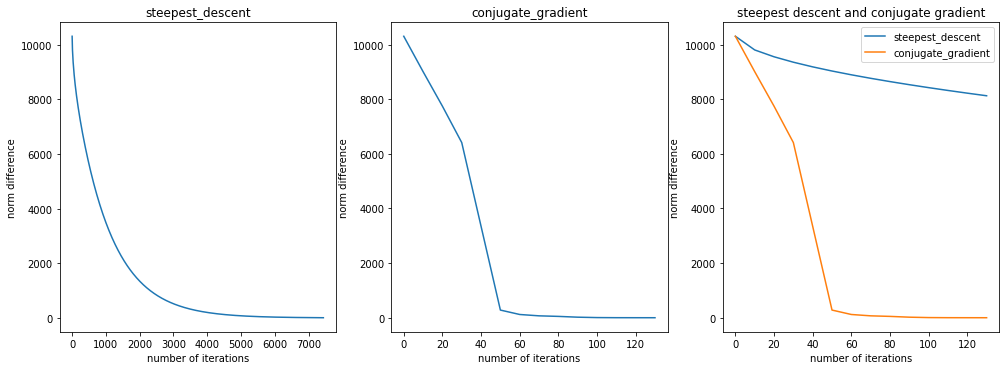

In [22]:
figure, axis = plt.subplots(1,3)
x_sd,y_sd = zip(*sorted(acc_sd.items()))
axis[0].plot(x_sd,y_sd)
axis[0].set_title("steepest_descent")
x_cg,y_cg = zip(*sorted(acc_cg.items()))
axis[1].plot(x_cg,y_cg)
axis[1].set_title('conjugate_gradient')
axis[2].plot(x_cg,y_sd[:len(x_cg)])
axis[2].plot(x_cg,y_cg)
axis[2].legend(['steepest_descent','conjugate_gradient'],loc = "upper right")
axis[2].set_title("steepest descent and conjugate gradient")
figure.subplots_adjust(hspace = 10,wspace = 0.2)
plt.subplots_adjust(top = 1.2,right = 2.3)
plt.setp(axis,xlabel = 'number of iterations')
plt.setp(axis,ylabel = 'norm difference')
plt.show()


#### Gibbs Sampling

In [23]:
def normal(mean,var):
    seed_lib()
    return mean +  math.sqrt(var) * float(torch.randn(1))

In [24]:
sigma = torch.linalg.inv(stiffness)

In [25]:
torch.count_nonzero(stiffness)/(1225 * 1225)

tensor(0.0040)

In [26]:
def gibbs_sampler(N,num_iter,start = torch.zeros(dim)):
    iter = num_iter
    x = torch.zeros((iter*N,N))
    for j in range(iter):
        for i in range(N):
            temp = torch.cat((start[:i],start[i+1:]))
            var = 1/stiffness[i][i]
            intermediate = (torch.cat((stiffness[i][:i],stiffness[i][i+1:]))/(-stiffness[i][i]))
            mean = intermediate @ temp.T
            start[i] = normal(mean,var)
            x[j*N+i] = start
    return x

def sigma_convergence(N,x,sigma,samples,num_iter,start = torch.zeros(dim)):
    sum = torch.zeros((N,N))
    burn_in = num_iter//2
    count = 0
    visited = 0
    if samples == 0:
        sum = sum + torch.outer(start,start.T)
        return torch.linalg.norm(sum-sigma)

    for j in range(burn_in,num_iter):
        for i in range(N):
            sum = sum  + torch.outer(x[j*N+i],x[j*N+i].T)/(samples)
            count += 1
            if count == samples:
                visited = 1
                break
        if visited == 1:
            break
    dist = torch.linalg.norm(sum-sigma)
    return dist

def conj_sigma_convergence(N,x,A,sigma,samples,num_iter):
    val = torch.zeros((N,N))
    burn_in = num_iter//2
    count = 0
    for j in range(burn_in,num_iter):
            val = val  + torch.outer(x[j*N],x[j*N].T)/(x[j*N][None,:] @ A @ x[j*N][:,None])
            count += 1
            if count == samples:
                break
    val = (val/samples)*N
    dist = torch.linalg.norm(val - sigma)
    return dist

def jump_sigma_convergence(N,x,sigma,samples,num_iter):
    new_sum = torch.zeros((N,N))
    burn_in = num_iter//2
    count = 0
    for j in range(burn_in,num_iter):
        new_sum = new_sum + torch.outer(x[j*N],x[j*N].T)/samples
        count += 1
        if count == samples:
            break
    dist = torch.linalg.norm(new_sum - sigma)
    return dist

In [27]:
num_iter = 10
start = torch.zeros(dim)
x = gibbs_sampler(dim ,num_iter,start)
norm = sigma_convergence(dim , x, sigma, num_iter * dim, num_iter)
print(f'Plane Gibbs sampling norm with {dim} samples = {norm}')

jump_norm = jump_sigma_convergence(dim , x, sigma, num_iter, num_iter)
print(f'Gibbs sampling norm with {dim} samples = {jump_norm}')

conj_norm = conj_sigma_convergence(dim , x, stiffness, sigma, num_iter, num_iter)
print(f'conjugate norm with {dim} samples = {conj_norm}')

/home/lohith/chida/environments/basic/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  if __name__ == "__main__":


Plane Gibbs sampling norm = 309.09326171875
Gibbs sampling norm with 1225 samples = 236.1492919921875
conjugate norm with 1225 samples = 326.6197204589844


#### Generating plots comparing the three convergence methods of Gibbs Sampler